### ANÁLISIS DE SERIES DE TIEMPO (VARIACIÓN DE VALOR DE DIFERENTES MONEDAS)

Considerando un dataset extraído de la api "oanda", que contiene el histórico de la variación por hora del valor de diferentes pares de monedas (EUR-USD, AUD-USD, etc), se propone lo siguiente: 

* Desarrollar un modelo ARIMA que permita predecir el precio de las monedas en días futuros (forecasting). 
sólo para una moneda por ejemplo, Euro - Dólar.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt 
import os
import math 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs

## 1. Lectura del Dataframe 

## 2. Descripción breve del DataFrame.

El DataFrame en estudio cuenta con 9  columnas y un total de 50000 filas. 

Las columnas contenidas en el DataFrame son: 

2.1 time: Hora en de apertura para cada periodo.

2.2 open_bid : Precio de apertura para la venta  a la hora indicada. 

2.3 high_bid : Precio más alto de venta del usuario para esa hora. 

2.4 low_bid : Precio más bajo de venta del usuario para esa hora.

2.5 close_bid: Precio de cierre para la venta a la hora indicada.

2.6 open_ask : Precio de apertura para la compra a la hora indicada. 

2.7 high_ask : Precio más alto de compra para el usuario para esa hora. 

2.8 low_ask : Precio más bajo de compra para usuario para esa hora.

2.9 close_ask : Precio de cierre para la compra a la hora indicada.

* Calcular con todas las monedas el retorno (precio actual - precio del pasado), y luego de ello construir una regresión lineal buscando discernir si el retorno de varias monedas (features) logra explicar el retorno de una combinación de moneda (target)

## Construcción modelo ARIMA

# Variación Dolar Euro

In [3]:
datos = pd.read_csv(r'EUR_USD_H1.csv')
print(datos.head)
print(f'El dataframe que se construye con las variaciones de cotización de par de moneda (Euro-Dólar) está compuesto por {datos.shape[1]} columnas y {datos.shape[0]} filas') 

df = datos[['open_bid', 'time']]
df.head()

<bound method NDFrame.head of                    time  open_bid  high_bid  low_bid  close_bid  open_ask  \
0      2015-01-28 02 AM   1.13343   1.13398  1.13299    1.13338   1.13358   
1      2015-01-28 03 AM   1.13335   1.13429  1.13335    1.13397   1.13352   
2      2015-01-28 04 AM   1.13399   1.13413  1.13317    1.13362   1.13414   
3      2015-01-28 05 AM   1.13358   1.13632  1.13329    1.13547   1.13373   
4      2015-01-28 06 AM   1.13544   1.13815  1.13524    1.13693   1.13561   
...                 ...       ...       ...      ...        ...       ...   
49995  2023-02-09 09 PM   1.07328   1.07380  1.07323    1.07380   1.07342   
49996  2023-02-09 10 PM   1.07345   1.07408  1.07345    1.07391   1.07421   
49997  2023-02-09 11 PM   1.07392   1.07412  1.07373    1.07384   1.07434   
49998        2023-02-10   1.07385   1.07386  1.07248    1.07341   1.07402   
49999  2023-02-10 01 AM   1.07340   1.07349  1.07304    1.07339   1.07355   

       high_ask  low_ask  close_ask  
0      

,open_bid,time
0,1.13343,2015-01-28 02 AM
1,1.13335,2015-01-28 03 AM
2,1.13399,2015-01-28 04 AM
3,1.13358,2015-01-28 05 AM
4,1.13544,2015-01-28 06 AM


In [4]:
# Cambio de columna a datetime
df['time'] = pd.to_datetime(df['time'])
df.index = df.time
df_ARIMA = df.drop(['time'], axis = 1)


C:\Users\mpire\AppData\Local\Temp\ipykernel_22248\418822103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


In [5]:
# Resample del DataFrame , calculando open_bid promedio por día. 
exchange_rate_1 = df_ARIMA.resample('D').agg({'open_bid':'mean'})
exchange_rate_1

,open_bid
time,
2015-01-28,1.133460
2015-01-29,1.130125
2015-01-30,1.131697
2015-01-31,NaN
2015-02-01,1.130895
...,...
2023-02-06,1.076015
2023-02-07,1.072053
2023-02-08,1.073121


In [6]:
# Para conocer la distribución de los datos 
exchange_rate_1.describe()

,open_bid
count,2507.000000
mean,1.127024
std,0.053879
min,0.961805
25%,1.094516
50%,1.124703
75%,1.168910
max,1.248688


In [7]:
# Para saber si existen valores nulos
exchange_rate_1.isnull().sum()

open_bid    429
dtype: int64

In [8]:
# Eliminar valores nulos 
exchange_rate = exchange_rate_1.dropna()

In [9]:
exchange_rate.shape

(2507, 1)

## 3. Distribución de los datos.  

array([[<AxesSubplot: title={'center': 'open_bid'}>]], dtype=object)

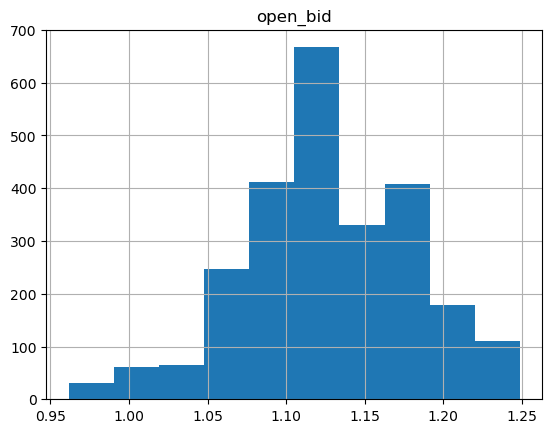

In [10]:
exchange_rate.hist()

### Variación temporal de la relación del precio de apertura entre EUR-USD

<AxesSubplot: xlabel='time'>

<Figure size 1000x900 with 0 Axes>

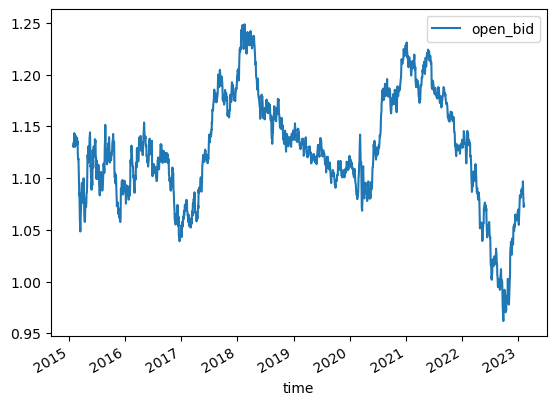

In [11]:
plt.figure(figsize=(10,9))
exchange_rate.plot()

### Generación de set de train y test

In [12]:
# Usaremos el 70% de los datos para train y el restante para test. 

training_data, testing_data = train_test_split(exchange_rate, test_size=0.3, random_state=42, shuffle=False)

#particion_datos = int(len(exchange_rate)*0.7)

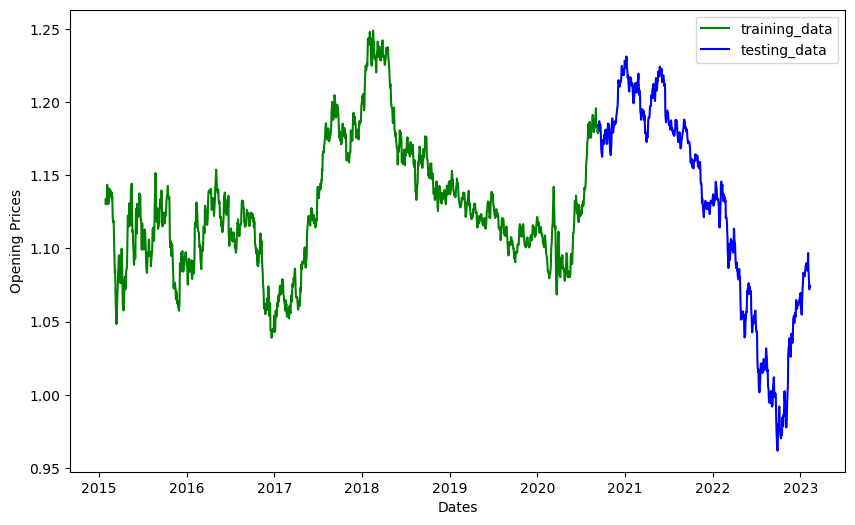

In [13]:
# Para ver gráficamente los datos de train y test

plt.figure(figsize=(10,6))
plt.grid=(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(training_data['open_bid'], 'green', label = 'training_data')
plt.plot(testing_data['open_bid'], 'blue', label = 'testing_data')
plt.legend()

In [14]:
test_data = list(testing_data['open_bid'])
train_data = list(training_data['open_bid'])

In [15]:
print(len(test_data))

753


## Para elegir p, d y q
* p: The number of lag observations included in the model, also called the lag order. 
* d: The number of times the raw observartion are differenced, also called the degree of differencing. 
* q: The size of the moving average window, also called the order of moving average. 


In [16]:
result = adfuller(exchange_rate['open_bid'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.054386
p-value: 0.263247
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### p-value mayor a 0.05 significa que la hipótesis nula no puede ser rechazada y esta serie puede ser tomada como no estacionaria. 

## Encontrando valor de parámetro "d"

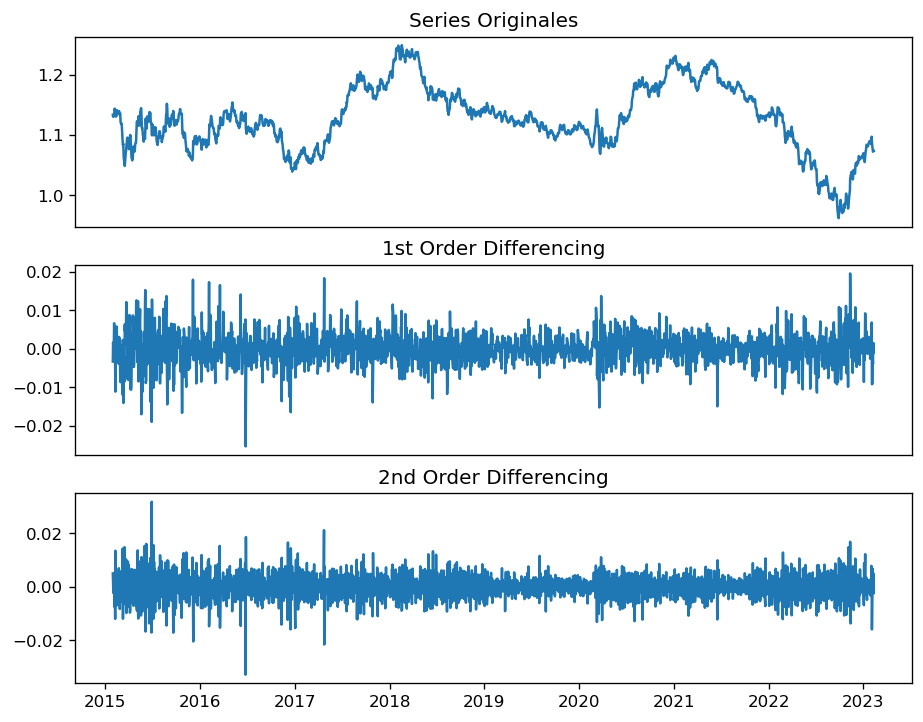

In [17]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Serie original
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(exchange_rate.open_bid); ax1.set_title('Series Originales'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(exchange_rate.open_bid.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(exchange_rate.open_bid.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

In [18]:
# Para hallar valor de "d"
ndiffs(exchange_rate.open_bid, test = 'adf' )

1

Hay mucha periodicidad en esta serie tiempo, lo que supone un valor para alto para "d". 
Esto se puede corroborar haciendo un gráfico de autocorrelación 

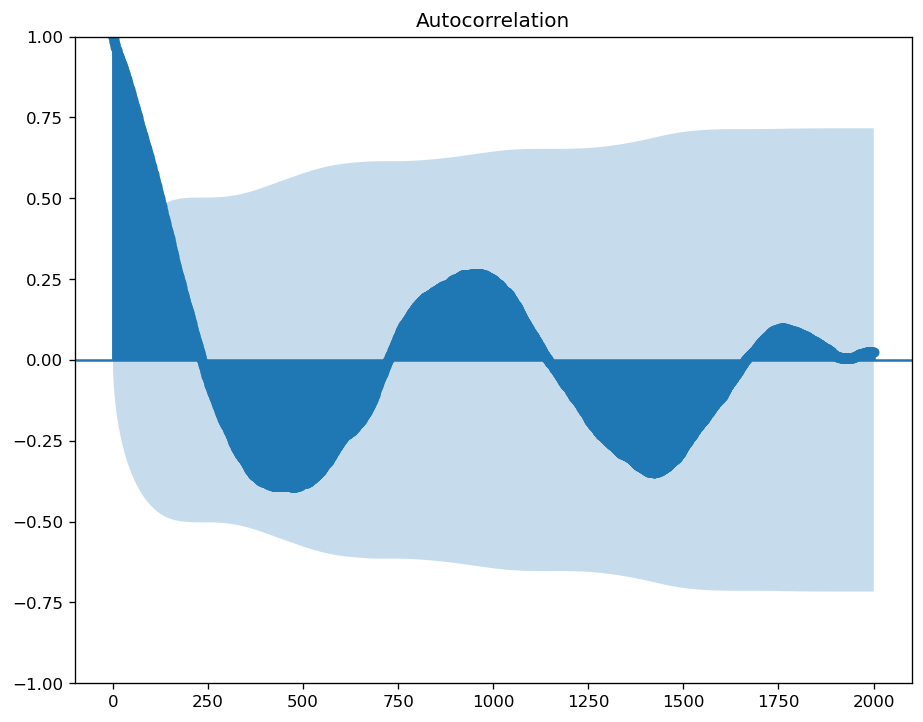

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots()
plot_acf(exchange_rate.open_bid, ax = ax, lags=2000);
# plot_acf(exchange_rate.open_bid.diff().dropna(), ax=ax2)
# plot_acf(exchange_rate.open_bid.diff().diff().dropna(), ax=ax3)

## Encontrando valor de parámetro "p"

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


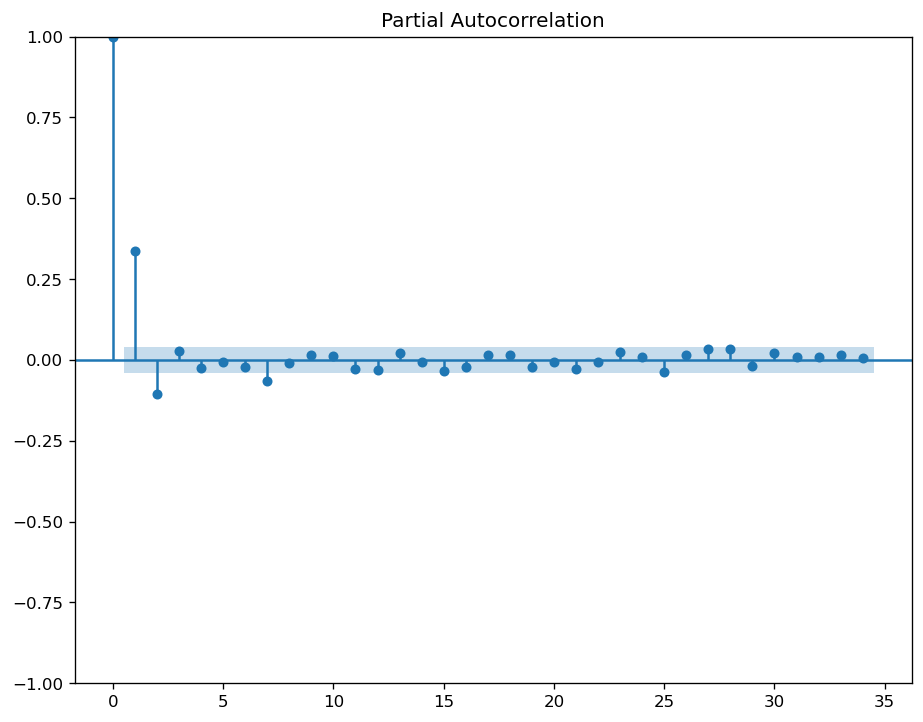

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(exchange_rate.open_bid.diff().dropna());

### Podría ser 0 el valor de "p" o  p = 3

## Encontrando valor de parámetro "q"

Para encontrar los valores de "q" podemos usar el gráfico de ACF, dicha gráfica nos dice cuanto promedio móvil se requiere para eliminar la autocorrelación de la serie de tiempo estacionaria. 

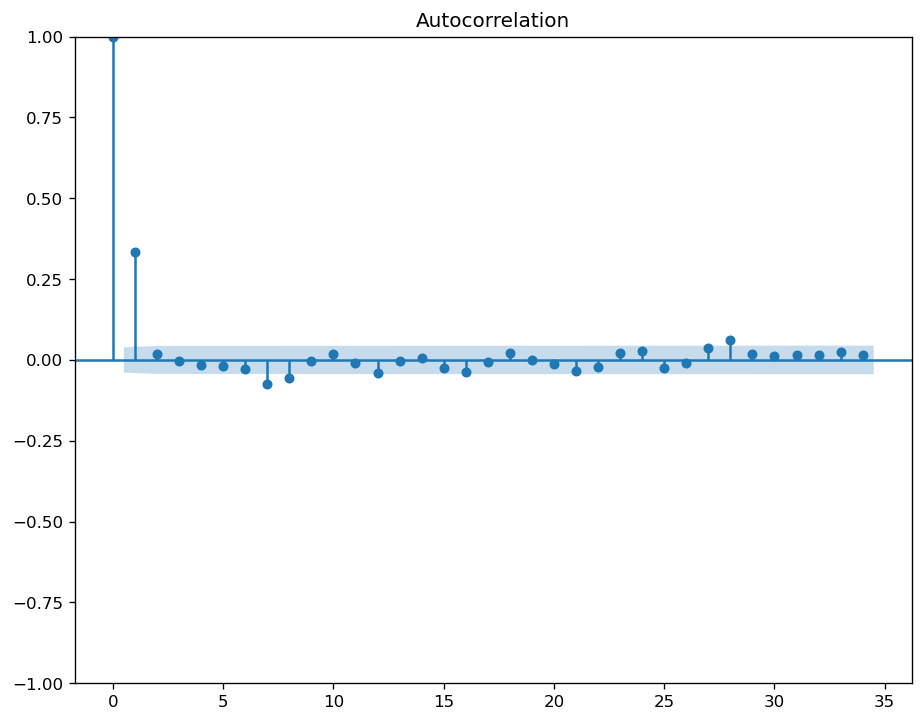

In [21]:
plot_acf(exchange_rate.open_bid.diff().dropna());

Aquí vemos que sólo 1 de los "lags" se encuentra fuera del límite de significancia , por lo que el valor óptimo de "q" es 1. 

primer argumento mas grande que 1

In [23]:
# Vamos a comenzar con valores de p,d y q, 
# Luego podemos usar Auto Arima  model
model = ARIMA(train_data, order = (500,0,2))
model_fit = model.fit()
y_pred= model_fit.forecast(len(test_data))
## y_pred = output
# print(y_pred)
# model_predictions.append(y_pred)
# cambiar nombre luego para variable y_actual
# actual_y = test_data[i]
# Para mantener actualizado el conjunto de train con la data histórica 
# train_data.append(actual_y)

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


KeyboardInterrupt: 

model = ARIMA(train_data, order = (100,0,2)) -- buena
model = ARIMA(train_data, order = (175,0,2)) -- 

In [ ]:
model_fit.summary()

NameError: name 'model_fit' is not defined

In [ ]:
print(len(model_predictions))
print(len(test_data))

0
753


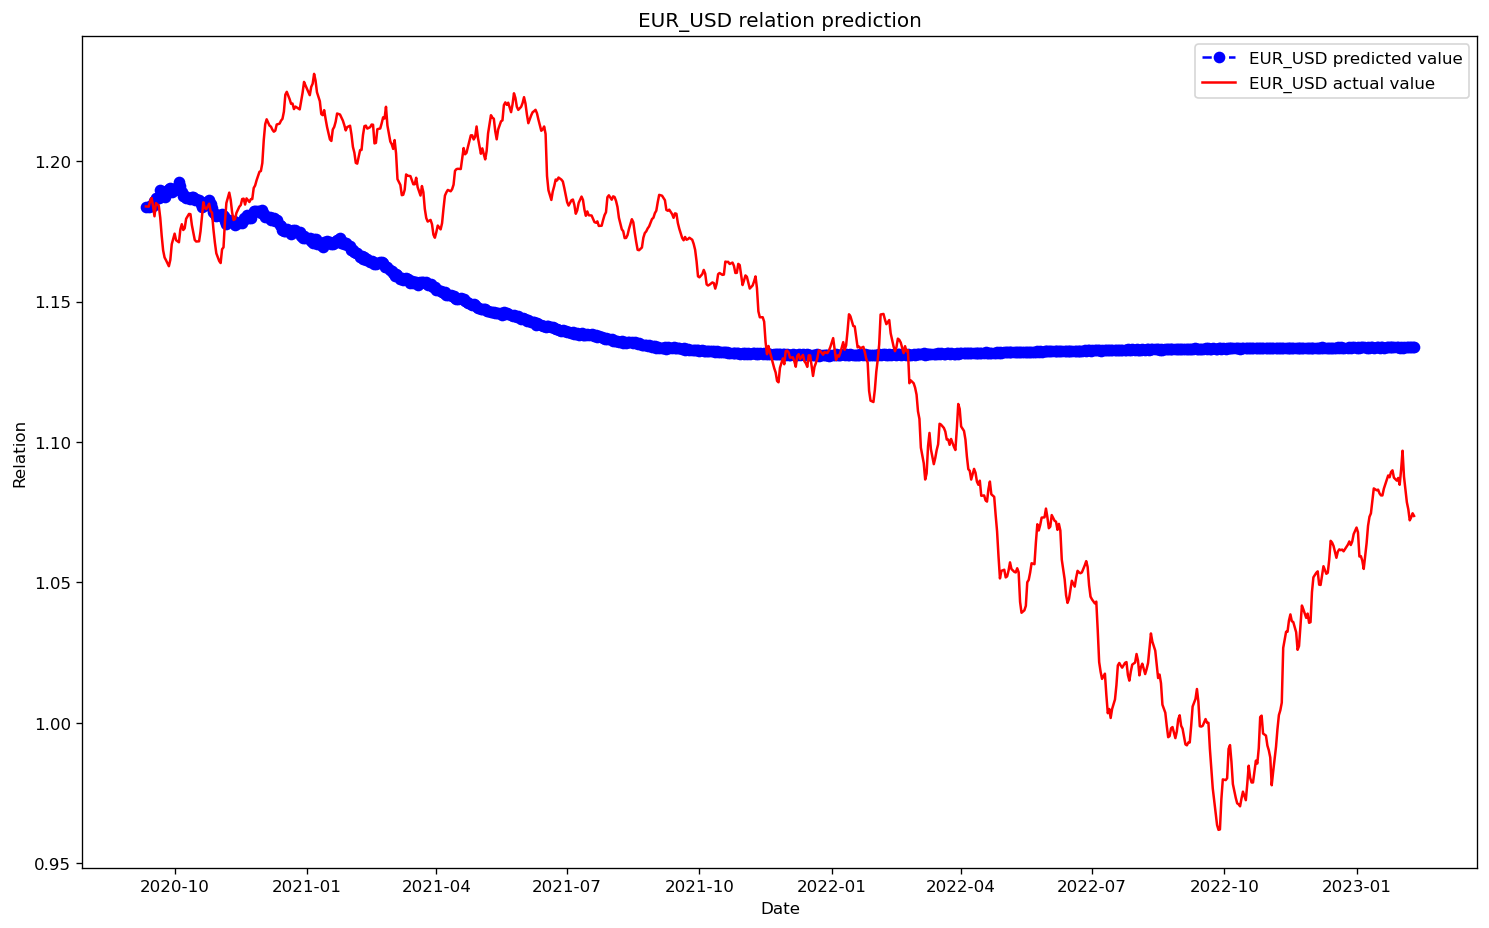

In [ ]:
plt.figure(figsize=(15,9))
plt.grid=(True)

date_range = exchange_rate[particion_datos:].index

plt.plot(date_range, y_pred, color = 'blue', marker = 'o', linestyle = 'dashed', label = 'EUR_USD predicted value')
plt.plot(date_range, test_data, color = 'red', label = 'EUR_USD actual value')

plt.title('EUR_USD relation prediction')
plt.xlabel('Date')
plt.ylabel('Relation')
plt.legend()
plt.show()